# Jake Singer Stripe Takehome Workbook
## Table of Contents

1. [Initial Setup](#initial-setup)
2. [Data Overview](#data-overview)
3. [Identifying Data Quality Issues](#identifying-issues)
4. [Cleaning Process](#cleaning-process)
   1. Mixed Type
      1. [Merchant Column](#merchant-column)
      2. [Industry Column](#industry-column)
      3. [First Charge Date Column](#first-charge-date)
   2. 
5. [Validation and Summary](#validation)

## 1. Initial Setup <a name="initial-setup"></a>

In [34]:
import pandas as pd
import numpy as np
import datetime

# Import merchants data
merchants = pd.read_excel('dstakehome_merchants.xlsx', parse_dates=['first_charge_date'])

# Import payments data
payments = pd.read_excel('dstakehome_payments.xlsx', parse_dates=['date'])

# Verify the data was imported correctly
print("Merchants table shape:", merchants.shape)
print("Payments table shape:", payments.shape)

Merchants table shape: (23627, 5)
Payments table shape: (1577887, 6)


## 2. Data Overview<a name="data-overview"></a>

Summary Statistics to get a lay of the land:

In [49]:
def print_dataframe_info(df, name):
    print(f"\n{name} DataFrame Overview:")
    print(df.info())

def check_mixed_types(df, df_name):
    print(f"\nChecking mixed types in {df_name}:")
    for column in df.columns:
        # Get unique types in the column
        unique_types = df[column].apply(type).unique()
        
        if len(unique_types) > 1:
            print(f"\nColumn '{column}' has mixed types:")
            for dtype in unique_types:
                count = (df[column].apply(type) == dtype).sum()
                print(f"  {dtype.__name__}: {count}")
        else:
            print(f"Column '{column}' only has one type: {unique_types[0].__name__}")

def summarize_merchants(df):
    print("\nMerchants Table Detailed Summary:")
    
    categorical_cols = ['industry', 'country', 'business_size']
    
    for col in categorical_cols:
        print(f"\nTop 10 {col} categories:")
        counts = df[col].value_counts()
        total = len(df)
        
        if len(counts) > 10:
            top_10 = counts.head(10)
            other = pd.Series({'Other': counts[10:].sum()})
            top_10 = pd.concat([top_10, other])
        else:
            top_10 = counts
        
        summary = pd.DataFrame({
            'Count': top_10,
            '% of Total': (top_10 / total * 100).round(2)
        })
        
        print(summary)

def summarize_payments(df):
    print("\nPayments Table Detailed Summary:")
    
    volume_cols = ['subscription_volume', 'checkout_volume', 'payment_link_volume', 'total_volume']
    
    for col in volume_cols:
        non_zero = df[df[col] > 0][col]
        zero_count = (df[col] == 0).sum()
        non_zero_count = len(non_zero)
        
        print(f"\n{col}:")
        print(f"Zero values: {zero_count:,} ({zero_count/len(df)*100:.2f}%)")
        print(f"Non-zero values: {non_zero_count:,} ({non_zero_count/len(df)*100:.2f}%)")
        
        if non_zero_count > 0:
            print("Summary statistics for non-zero values:")
            stats = non_zero.describe()
            print(f"Ratio of mean to median: {non_zero.mean()/non_zero.median()}")
            print(stats.apply(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x))

# Example usage
print_dataframe_info(merchants, "Merchants")
summarize_merchants(merchants)

print_dataframe_info(payments, "Payments")
summarize_payments(payments)

# Run the mixed type function on both dataframes
check_mixed_types(payments, "Payments")
check_mixed_types(merchants, "Merchants")



Merchants DataFrame Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23627 entries, 0 to 23626
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   merchant           23627 non-null  object
 1   industry           23627 non-null  object
 2   first_charge_date  23627 non-null  object
 3   country            23627 non-null  object
 4   business_size      23627 non-null  object
dtypes: object(5)
memory usage: 923.1+ KB
None

Merchants Table Detailed Summary:

Top 10 industry categories:
                       Count  % of Total
Business services       3144       13.31
Software                2167        9.17
Merchandise             1988        8.41
Personal services       1922        8.13
Others                  1732        7.33
Digital goods           1379        5.84
Education               1332        5.64
Clothing & accessory    1303        5.51
Food & drink            1275        5.40
Grocery & f

There are a few key points to highlight about the data that is beyond what is included in the data description file. This is useful just to develop some intuition around the data:

1. The payments table includes 1.6M rows of daily merchant payment volume. Most of the rows have a 0 for at least one of the three columns. There are significant long tails in each of these columns. Even after excluding the zero rows for each of the payments volume, the ratio of the mean to the median is large. This is especially true for subscription and total revenue.
2. Merchants are relatively evenly distributed by industry, but are more concentrated by country (about 50% of records in the US and GB). Merchants are even more concentrated by size, where over 90% of records are considered 'small'.
3. There a few columns that have 'mixed types', as in columns that have more than 1 data type. For merchant and industry, we'll cast all values to string.
4. Finally, the first_charge_date column is type 'object', and I want to make sure that is in the data type of datetime so we can more reliably run operations on it.

To go deeper in understanding the data, I want to merge the data so I can start to segment the payments data by merchant attributes. 

Merged Data Exploration

Step 1: Merge and Verify Quality

In [131]:
try:
    pd.to_datetime(merchants[merchants['first_charge_date'] != 0]['first_charge_date'])
    print("Conversion successful")
except Exception as e:
    print(f"Conversion failed: {e}")

Conversion successful


In [132]:
# Perform the merge
payments['merchant'] = payments['merchant'].astype(str)
merchants['merchant'] = merchants['merchant'].astype(str)
merchants['industry'] = merchants['industry'].astype(str)

merged_df = pd.merge(payments, merchants, on='merchant', how='left')

# 1. Check the shape of the dataframes
print("Shape of payments:", payments.shape)
print("Shape of merchants:", merchants.shape)
print("Shape of merged dataframe:", merged_df.shape)
print("Extra Rows as result of merge:", len(merged_df) - len(payments))

# 2. Check for null values in key columns
print("\nNull values in 'business_size' column:")
print(merged_df['business_size'].isnull().sum())

# 3. Compare unique merchants before and after merge
print("\nUnique merchants in payments:", payments['merchant'].nunique())
print("Unique merchants in merged dataframe:", merged_df['merchant'].nunique())

# 4. Check for any duplicate rows
print("\nNumber of duplicate rows:", merged_df.duplicated().sum())

# 5. Sample a few rows to manually verify
print("\nSample of merged dataframe:")
print(merged_df.sample(5))

# 6. Check for unexpected column names
print("\nColumns in merged dataframe:")
print(merged_df.columns)


Shape of payments: (1577887, 6)
Shape of merchants: (23627, 5)
Shape of merged dataframe: (1578937, 10)
Extra Rows as result of merge: 1050

Null values in 'business_size' column:
0

Unique merchants in payments: 23620
Unique merchants in merged dataframe: 23620

Number of duplicate rows: 0

Sample of merged dataframe:
                             date  merchant  subscription_volume  \
202394  2041-06-28 00:00:00+00:00  a5be8120                    0   
561528  2041-10-06 00:00:00+00:00  43070792                    0   
917612  2042-01-09 00:00:00+00:00  6e3bb539                    0   
1062776 2042-02-15 00:00:00+00:00  259116dd                    0   
183883  2041-06-22 00:00:00+00:00  863fc043                56989   

         checkout_volume  payment_link_volume  total_volume  \
202394             12074                    0         12074   
561528                 0                    0          5745   
917612                 0                    0        203194   
1062776           

From here we can see the merge is mostly successful, but we have 1,050 extra rows created. My guess is this is related to duplicate merchants in one of the tables.

In [133]:
# Check for duplicate merchants in the merchants table
duplicate_merchants = merchants[merchants.duplicated(subset='merchant', keep=False)]
print("Number of duplicate merchant entries:", len(duplicate_merchants))
print("\nSample of duplicate merchants:")
print(duplicate_merchants)

# Check how many payments are affected by these duplicates
affected_payments = payments[payments['merchant'].isin(duplicate_merchants['merchant'])]
print("\nNumber of payments affected by duplicate merchants:", len(affected_payments))

Number of duplicate merchant entries: 8

Sample of duplicate merchants:
      merchant           industry          first_charge_date country  \
11282        0         Healthcare  2040-12-08 00:00:00+00:00      US   
11606        0        Merchandise  2038-11-30 00:00:00+00:00      CA   
13020        0          Education  2041-07-15 00:00:00+00:00      MX   
13384        0             Others  2041-07-24 00:00:00+00:00      GB   
18458        0  Business services  2041-12-16 00:00:00+00:00      US   
20739        0             Others  2042-03-10 00:00:00+00:00      US   
21151        0             Others  2042-03-26 00:00:00+00:00      GB   
22686        0            Leisure  2042-05-22 00:00:00+00:00      SG   

      business_size  
11282         small  
11606         small  
13020         small  
13384         small  
18458         small  
20739         small  
21151         small  
22686         small  

Number of payments affected by duplicate merchants: 150


This suggests there are 8 duplicated merchants, who all have the id of "0". Let's explore these and big of an issue this is:

In [134]:
zero_merchant_payments_original = payments[payments['merchant'] == '0']
zero_merchant_payments_merged = merged_df[merged_df['merchant'] == '0']

def sci_to_percent(sci_str):
    # Convert scientific notation to float
    num = float(sci_str)
    
    # Convert to percentage
    percent = num * 100
    
    # Format as percentage string
    percent_str = f"{percent:.4f}%"
    
    return percent_str


print("Percent of total payment volume connected to '0' merchant", sci_to_percent(zero_merchant_payments_original['total_volume'].sum() / payments['total_volume'].sum())) 
print("Percent of total rows connected to '0' merchant", sci_to_percent(len(zero_merchant_payments_original) / len(payments))) 

Percent of total payment volume connected to '0' merchant 0.0005%
Percent of total rows connected to '0' merchant 0.0095%


Based on this, the volumes are really small, so I think we can just go back to the original tables and just re-do the mege, but this time filtering out merchants with ID = '0':

In [142]:
# Perform the merge
merchants_filtered = merchants[(merchants['merchant'] != '0') & (merchants['first_charge_date'] != 0)]
payments_filtered = payments[payments['merchant'] != '0']

merged_df_filtered = pd.merge(payments_filtered, merchants_filtered, on='merchant', how='left')

# 1. Check the shape of the dataframes
print("Shape of payments:", payments_filtered.shape)
print("Shape of merchants:", merchants_filtered.shape)
print("Shape of merged dataframe:", merged_df_filtered.shape)
print("Extra Rows as result of merge:", len(merged_df_filtered) - len(payments_filtered))

# 2. Check for null values in key columns
print("\nNull values in 'business_size' column:")
print(merged_df_filtered['business_size'].isnull().sum())

# 3. Compare unique merchants before and after merge
print("\nUnique merchants in payments:", payments_filtered['merchant'].nunique())
print("Unique merchants in merged dataframe:", merged_df_filtered['merchant'].nunique())

# 4. Check for any duplicate rows
print("\nNumber of duplicate rows:", merged_df_filtered.duplicated().sum())

# 5. Sample a few rows to manually verify
print("\nSample of merged dataframe:")
print(merged_df_filtered.sample(5))

# 6. Check for unexpected column names
print("\nColumns in merged dataframe:")
print(merged_df_filtered.columns)


Shape of payments: (1577737, 6)
Shape of merchants: (23593, 5)
Shape of merged dataframe: (1577737, 10)
Extra Rows as result of merge: 0

Null values in 'business_size' column:
1099

Unique merchants in payments: 23619
Unique merchants in merged dataframe: 23619

Number of duplicate rows: 0

Sample of merged dataframe:
                             date  merchant  subscription_volume  \
1382832 2042-05-05 00:00:00+00:00  98b34533                 5900   
1080684 2042-02-19 00:00:00+00:00  7ceba44a                    0   
811568  2041-12-10 00:00:00+00:00  afb3b688                    0   
47384   2041-05-14 00:00:00+00:00  395ddaf7                    0   
1262996 2042-04-06 00:00:00+00:00  22fb5b37                    0   

         checkout_volume  payment_link_volume  total_volume  \
1382832             5900                    0          5900   
1080684                0                    0          7588   
811568                 0                    0         20910   
47384             

OK so we now have a merged dataframe. Before doing more analysis, I want to do a few final quality checks:
* That transaction dates in payments 'date' column aren't too far outside of the range we are expecting (2041-42)
* That the 'first_charge_date' reflects what we see in date - like we should not have payments occuring before the first_charge_date for a given merchant.


1. Checking transaction date range:
   Minimum date: 2041-05-01 00:00:00+00:00
   Maximum date: 2042-06-22 00:00:00+00:00


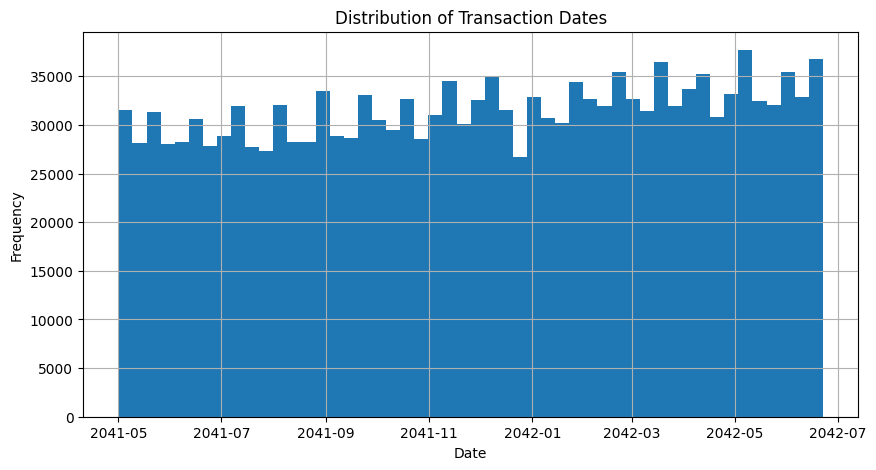


2. Checking first_charge_date consistency:
   Number of inconsistent records: 8
   Percentage of inconsistent records: 0.00%

Sample of inconsistent records:
        merchant                      date         first_charge_date
349510  4e91a7c6 2041-08-08 00:00:00+00:00 2041-09-05 00:00:00+00:00
353121  4e91a7c6 2041-08-09 00:00:00+00:00 2041-09-05 00:00:00+00:00
356832  4e91a7c6 2041-08-10 00:00:00+00:00 2041-09-05 00:00:00+00:00
627961  f3b90aa7 2041-10-24 00:00:00+00:00 2041-12-06 00:00:00+00:00
779333  b3b86d1c 2041-12-02 00:00:00+00:00 2041-12-03 00:00:00+00:00


In [145]:
import matplotlib.pyplot as plt

def quality_check(df):
    # Check 1: Transaction dates range
    print("1. Checking transaction date range:")
    min_date = df['date'].min()
    max_date = df['date'].max()
    print(f"   Minimum date: {min_date}")
    print(f"   Maximum date: {max_date}")
    
    # Visualize date distribution
    plt.figure(figsize=(10,5))
    df['date'].hist(bins=50)
    plt.title('Distribution of Transaction Dates')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.show()

    # Check 2: first_charge_date vs date
    print("\n2. Checking first_charge_date consistency:")
    inconsistent = df[df['date'] < df['first_charge_date']]
    inconsistent_count = len(inconsistent)
    total_count = len(df)
    inconsistent_percentage = (inconsistent_count / total_count) * 100

    print(f"   Number of inconsistent records: {inconsistent_count}")
    print(f"   Percentage of inconsistent records: {inconsistent_percentage:.2f}%")

    if inconsistent_count > 0:
        print("\nSample of inconsistent records:")
        print(inconsistent[['merchant', 'date', 'first_charge_date']].head())

    return inconsistent

# Assuming your merged dataframe is called 'merged_df'
inconsistent_records = quality_check(merged_df_filtered)

This makes me feel pretty good - there are 8 "inconsistent" records, but the dates are close enough, and the volume is low enough that I'm happy to ignore these.

## Segmentation Analysis

/var/folders/_n/13y551gd1zd94tk3yv0s24xc0000gn/T/ipykernel_31658/4124316229.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_companies['offers_subscription'] = small_companies['merchant'].isin(merchants_with_subscriptions)
/var/folders/_n/13y551gd1zd94tk3yv0s24xc0000gn/T/ipykernel_31658/4124316229.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key='date', freq='M'),


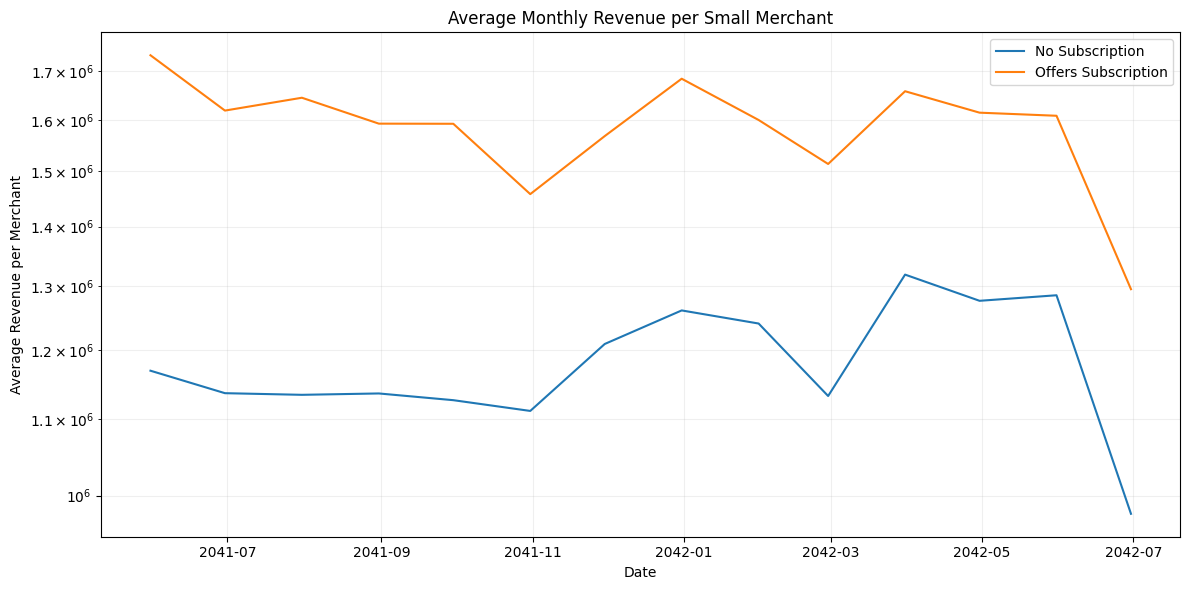

                     count       mean       std        min        25%  \
offers_subscription                                                     
False                14.00 1179572.57  90750.41  977477.07 1133094.28   
True                 14.00 1584572.73 107402.35 1294622.17 1574019.25   

                           50%        75%        max  
offers_subscription                                   
False               1152890.92 1255551.17 1318455.54  
True                1604070.88 1638446.76 1734787.95  


In [194]:
from scipy import stats
import matplotlib.pyplot as plt

df = merged_df_filtered.sort_values(['date'])

# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter to small companies only
small_companies = df[df['business_size'] == 'small']

# Create a column to identify if a merchant ever offered subscriptions
merchants_with_subscriptions = small_companies[small_companies['subscription_volume'] > 0]['merchant'].unique()
small_companies['offers_subscription'] = small_companies['merchant'].isin(merchants_with_subscriptions)

# Group by month and subscription offering status, calculate average monthly revenue
monthly_revenue = small_companies.groupby([
    pd.Grouper(key='date', freq='M'),
    'offers_subscription'
]).agg({
    'total_volume': 'sum',
    'merchant': 'nunique'
}).reset_index()

# Calculate average monthly revenue per merchant
monthly_revenue['avg_revenue_per_merchant'] = monthly_revenue['total_volume'] / monthly_revenue['merchant']

# Plot
plt.figure(figsize=(12, 6))
for offers_subscription, group in monthly_revenue.groupby('offers_subscription'):
    label = 'Offers Subscription' if offers_subscription else 'No Subscription'
    plt.plot(group['date'], group['avg_revenue_per_merchant'], label=label)

plt.title('Average Monthly Revenue per Small Merchant')
plt.xlabel('Date')
plt.ylabel('Average Revenue per Merchant')
plt.legend()
plt.yscale('log')  # Using log scale for better visualization if there's a large difference
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

# Print some summary statistics
print(monthly_revenue.groupby('offers_subscription')['avg_revenue_per_merchant'].describe())

In [198]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Assuming df is your original dataframe
# First, let's prepare the data

# Create a column to identify if a merchant ever offered subscriptions
merchants_with_subscriptions = df[df['subscription_volume'] > 0]['merchant'].unique()
df['offers_subscription'] = df['merchant'].isin(merchants_with_subscriptions)

# Group by merchant to get one row per merchant
merchant_summary = df.groupby('merchant').agg({
    'total_volume': 'sum',
    'offers_subscription': 'max',
    'country': 'first',
    'business_size': 'first',
    'industry': 'first'
}).reset_index()

# Convert categorical variables to dummy variables
merchant_summary = pd.get_dummies(merchant_summary, columns=['country', 'business_size', 'industry'], drop_first=True)

# Replace spaces and special characters in column names
merchant_summary.columns = merchant_summary.columns.str.replace(' ', '_').str.replace('[^0-9a-zA-Z_]', '', regex=True)

# Prepare the formula for regression
formula = 'np.log(total_volume) ~ offers_subscription + ' + ' + '.join([col for col in merchant_summary.columns if col not in ['merchant', 'total_volume', 'offers_subscription']])

# Fit the model
model = ols(formula, data=merchant_summary).fit()

# Print the summary
print(model.summary())

# Print key metrics
print("\nKey Metrics:")
print(f"R-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
print(f"F-statistic: {model.fvalue:.4f}")
print(f"Prob (F-statistic): {model.f_pvalue:.4f}")

# Print coefficient for 'offers_subscription'
subscription_coef = model.params['offers_subscription']
subscription_pvalue = model.pvalues['offers_subscription']
print(f"\nCoefficient for 'offers_subscription': {subscription_coef:.4f}")
print(f"P-value for 'offers_subscription': {subscription_pvalue:.4f}")

# Calculate the percentage impact of offering subscriptions
percentage_impact = (np.exp(subscription_coef) - 1) * 100
print(f"Percentage impact of offering subscriptions: {percentage_impact:.2f}%")

# Print top 5 most significant variables (excluding the intercept)
top_variables = model.pvalues.sort_values()[1:6]
print("\nTop 5 most significant variables:")
for var, p_value in top_variables.items():
    coef = model.params[var]
    print(f"{var}: Coefficient = {coef:.4f}, P-value = {p_value:.4f}")

                             OLS Regression Results                             
Dep. Variable:     np.log(total_volume)   R-squared:                       0.084
Model:                              OLS   Adj. R-squared:                  0.081
Method:                   Least Squares   F-statistic:                     28.90
Date:                  Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                          17:35:34   Log-Likelihood:                -60103.
No. Observations:                 23619   AIC:                         1.204e+05
Df Residuals:                     23543   BIC:                         1.210e+05
Df Model:                            75                                         
Covariance Type:              nonrobust                                         
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

KeyError: 'offers_subscription'

In [201]:
import pandas as pd

# Step 1: Aggregate data monthly or weekly for all merchants
# You can adjust the frequency to 'M' for monthly or 'W' for weekly as needed
df_agg = df.groupby(['merchant', pd.Grouper(key='date', freq='M')])['total_volume', 'subscription_volume, '].sum().reset_index()

# Step 2: Identify adoption of subscriptions
df_agg['adopted_subscriptions'] = (df_agg['subscription'] > 0) & (df_agg['subscription'].shift(1) == 0)

# Get a list of merchants who adopted subscriptions and their adoption dates
adoption_dates = df_agg[df_agg['adopted_subscriptions']][['merchant', 'date']]

# Prepare to store results
results = []

# Iterate through each merchant and their adoption date
for _, row in adoption_dates.iterrows():
    merchant = row['merchant']
    adoption_date = row['date']
    
    # Define periods
    pre_adoption_start = adoption_date - pd.DateOffset(months=12)
    post_adoption_end = adoption_date + pd.DateOffset(months=12)
    
    # Filter aggregated data for the merchant
    merchant_data = df_agg[df_agg['merchant'] == merchant]
    
    # Get pre- and post-adoption data
    pre_adoption_data = merchant_data[(merchant_data['date'] >= pre_adoption_start) & (merchant_data['date'] < adoption_date)]
    post_adoption_data = merchant_data[(merchant_data['date'] > adoption_date) & (merchant_data['date'] <= post_adoption_end)]
    
    # Check if we have enough data points
    if len(pre_adoption_data) < 1 or len(post_adoption_data) < 1:  # Example threshold for existence
        continue  # Skip this merchant if not enough data
    
    # Calculate total volume before and after
    total_volume_pre = pre_adoption_data['total_volume'].sum()
    total_volume_post = post_adoption_data['total_volume'].sum()
    
    # Calculate growth rate
    if total_volume_pre > 0:
        growth_rate = (total_volume_post - total_volume_pre) / total_volume_pre
    else:
        growth_rate = None  # Handle cases with no pre-adoption sales
    
    # Store the result
    results.append({
        'merchant': merchant,
        'adoption_date': adoption_date,
        'total_volume_pre': total_volume_pre,
        'total_volume_post': total_volume_post,
        'growth_rate': growth_rate
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Optional: Clean up and analyze the results
print(results_df)


KeyboardInterrupt: 